<a href="https://colab.research.google.com/github/fursuf1/Credit-Card-Fraud-Detection/blob/main/src/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the library required for uploading to and downloading from Colab
!pip install opendatasets
!pip install kaggle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od

In [ ]:
# Import the necessary module requred to upload the json file containing the user's Kaggle username and API key
from google.colab import files
files.upload()

In [4]:
# Make the directory necessar to place the Kaggle json credentials file. RUN THIS ONLY ONCE PER SESSION
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the CC data set from Kaggle
od.download("https://www.kaggle.com/datasets/kartik2112/fraud-detection")

100%|██████████| 202M/202M [00:08<00:00, 24.7MB/s]


In [6]:
# Import data as DataFrames
fraud_test = pd.read_csv('./fraud-detection/fraudTest.csv', index_col=0)
fraud_train = pd.read_csv('./fraud-detection/fraudTrain.csv', index_col=0)

In [29]:
# Combine the DF's into a single DF
fraud_df = pd.concat([fraud_train, fraud_test])

In [30]:
# Convert columns to date/datetime format where possible
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
fraud_df['dob'] = pd.to_datetime(fraud_df['dob'])

In [31]:
# Add a new column with times converted from the Unix time column into datetime format
fraud_df['from_unix_time'] = pd.to_datetime(fraud_df['unix_time'], unit='s')

In [32]:
# Create a column with first and last names
fraud_df['full_name'] = fraud_df['first'] + ' ' + fraud_df['last']

In [33]:
# Drop the transaction number column as it has no analytical use
fraud_df.drop('trans_num', axis=1, inplace=True)

In [34]:
# Drop the 'fraud_' from the merchants' names
fraud_df['merchant'] = fraud_df['merchant'].str.lstrip('fraud_')

In [35]:
# Make a list of columns to rearrange the DF
rearranged_cols = list(fraud_df.columns)[0:7] + ['full_name'] + list(fraud_df.columns) [7:18] + ['from_unix_time'] + list(fraud_df.columns)[18:21]

In [36]:
# Rearrange the columns
fraud_df = fraud_df[rearranged_cols]

In [37]:
# Add a column for transaction time in epoch format
fraud_df['trans_date_trans_time_unix_time'] = fraud_df['trans_date_trans_time'].astype('int64')//1e9

In [38]:
# Create columns with hour from date, day from date, weekday from date, and month from date
fraud_df['trans_hour'] = fraud_df['trans_date_trans_time'].dt.hour
fraud_df['trans_day'] = fraud_df['trans_date_trans_time'].dt.day
fraud_df['trans_weekday'] = fraud_df['trans_date_trans_time'].dt.weekday
fraud_df['trans_month'] = fraud_df['trans_date_trans_time'].dt.month

In [39]:
fraud_df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,trans_date_trans_time_unix_time,trans_hour,trans_day,trans_weekday,trans_month
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03,1.579556e+09,1.280612e+01,1.585076e+01,2.967456e+00,7.152067e+00
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02,1.822443e+07,6.815753e+00,8.876245e+00,2.197983e+00,3.424954e+00
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00,1.546301e+09,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00,1.563855e+09,7.000000e+00,8.000000e+00,1.000000e+00,4.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00,1.577928e+09,1.400000e+01,1.600000e+01,3.000000e+00,7.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00,1.595506e+09,1.900000e+01,2.400000e+01,5.000000e+00,1.000000e+01
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00,1.609459e+09,2.300000e+01,3.100000e+01,6.000000e+00,1.200000e+01


In [41]:
# Create target and feature dataframes. Taking out unix_time and zip due to high correlations with other variables
X = fraud_df[['trans_date_trans_time_unix_time', 'trans_hour', 'trans_day', 'trans_weekday', 'trans_month', 'cc_num', 'amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']]
y = fraud_df['is_fraud']

In [42]:
# Import the necessary scikit-learn modules for model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [43]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [44]:
# Train the model using logistic regression, n_jobs set to -1 so that all cores available are used
logistic_regression = LogisticRegression(n_jobs=-1)
logistic_regression.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

In [45]:
# Predict fraud using the newly created model on the test set for comparison
y_pred = logistic_regression.predict(X_test)

In [46]:
# Evaluate the results
print(metrics.accuracy_score(y_test, y_pred))

0.9949281875625879


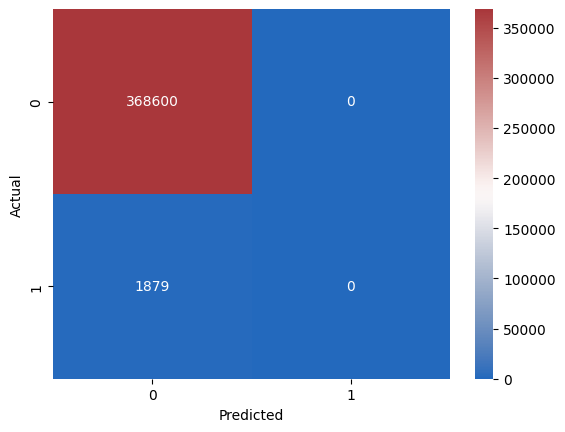

In [47]:
# Print a confusion matrix
fraud_confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(fraud_confusion_matrix, annot=True, annot_kws={'size': 10}, cmap='vlag', fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [48]:
# Logistic regression using the statsmodels module
import statsmodels.api as sm

In [49]:
# Fitting the model (adding the constant to X in one line so as to keep X as it is)
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.029655
         Iterations 10


In [50]:
# Summarize the result
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:              1481915
Model:                          Logit   Df Residuals:                  1481902
Method:                           MLE   Df Model:                           12
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                 0.09498
Time:                        23:25:27   Log-Likelihood:                -43947.
converged:                       True   LL-Null:                       -48559.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.8644      1.183      2.422      0.015       0.547       5.182
trans_date_trans_time_unix_time -5.415e-09   7.54e-10     -7.184    

In [54]:
# Try second model with anything higher than a P-value of 0.05 dropped

X_train2 = X_train.drop(['trans_day', 'cc_num', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long'], axis=1)

logit_model2 = sm.Logit(y_train, sm.add_constant(X_train2))
result2 = logit_model2.fit()

Optimization terminated successfully.
         Current function value: 0.029662
         Iterations 10


In [55]:
# Summarize the new result
print(result2.summary())

                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:              1481915
Model:                          Logit   Df Residuals:                  1481909
Method:                           MLE   Df Model:                            5
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                 0.09478
Time:                        23:31:00   Log-Likelihood:                -43957.
converged:                       True   LL-Null:                       -48559.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               2.9998      1.176      2.551      0.011       0.695       5.305
trans_date_trans_time_unix_time -5.414e-09   7.53e-10     -7.189    